For each protein sequence, separate graphs are created with nodea as amino acids and the edge weights are combination of both spatial distance and protein similarity from ProtBERT embeddings.
ProtBERT embeddings passed as node features for each tokenized amino acid in the separate graphs.
Spatial distances calculated with Manhattan distance and there is a threshold for the distance if two amino acids are connected in a spatial way or not.

In [1]:
import networkx as nx
from Bio.PDB import PDBParser
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cosine

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

* Takes a protein sequence and generates embeddings for each residue (amino acid) in the sequence

In [3]:
def get_residue_embeddings(sequence):
   
    tokenized_seq = " ".join(list(sequence)) # split the sequence into individual aa separated by space
    print(f"Tokenized sequence: {tokenized_seq}")
    inputs = tokenizer(tokenized_seq, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_state = outputs.last_hidden_state

    embeddings = last_hidden_state[0, 1:-1].cpu().numpy() # [1:-1] removes special tokens which are [CLS] and [SEP]
    print(f"Embeddings shape: {embeddings.shape}") # Embeddings shape: (64, 1024) --> (sequence_length, embedding_dim)
    print(f"Example embeddings: {embeddings[:5]}")
    
    return embeddings

In [4]:
print(model)
print(tokenizer)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

* residue_list hold the 3D coords of each residue
* residue_to_seq_idx store the mapping between the residue ID and position in the sequence
* For each residue in the 3D structure, get its residue ID and name
    * Retrieve its CA atom coordinates --> spatial position of the residue
* Each residue is added as a node to the graph with 
    * residue_name --> amino acid type
    * coords --> 3D coords of the CA atom
    * embedding --> 1024 dim embedding representing the residue
    * position --> index in the sequence
* edges are added between residues if their spatial distance is below a certain threshold
    * spatial dist --> 3D Euclidean distance between the residues' CA atom coordinates
    * embedding sim --> cosine similarity between the embedding vectors of two residues
    * combined weight --> combination of spatial distance and embedding similarity is used to compute the edge weight
* The protein sequence and a global embedding (mean of all residue embeddings) are stored as graph-level attributes

In [5]:
def create_enhanced_protein_graph(pdb_file, sequence, distance_threshold=5.0, embedding_weight=0.5):
  
    residue_embeddings = get_residue_embeddings(sequence)
    
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    G = nx.Graph()
    
    aa_dict = {
        'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 
        'C': 'CYS', 'E': 'GLU', 'Q': 'GLN', 'G': 'GLY', 
        'H': 'HIS', 'I': 'ILE', 'L': 'LEU', 'K': 'LYS', 
        'M': 'MET', 'F': 'PHE', 'P': 'PRO', 'S': 'SER', 
        'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
    }
    
    residue_list = []
    residue_to_seq_idx = {} 
    
    for model in structure:
        for chain in model:
            seq_idx = 0  # Index in the sequence
            for residue in chain:
                if 'CA' in residue:
                    residue_id = residue.get_id()[1]  # Residue number
                    residue_name = residue.get_resname()  # Amino acid type (3-letter code)
                    coords = residue['CA'].get_coord()  # CA atom coordinates
                    
                    # Get the corresponding embedding if available
                    if seq_idx < len(residue_embeddings):
                        embedding = residue_embeddings[seq_idx]
                    else:
                        embedding = np.zeros(1024) 
            
                    G.add_node(residue_id, 
                              residue_name=residue_name,
                              coords=coords,
                              position=seq_idx,
                              embedding=embedding,
                              one_letter=sequence[seq_idx] if seq_idx < len(sequence) else 'X')
                    
                    residue_list.append((residue_id, coords))
                    residue_to_seq_idx[residue_id] = seq_idx
                    seq_idx += 1
    
    # edges with combined weights (spatial + embedding similarity)
    for i, (res_i, coord_i) in enumerate(residue_list):
        for j, (res_j, coord_j) in enumerate(residue_list[i+1:], i+1):

            spatial_distance = np.linalg.norm(coord_i - coord_j) # Manhattan distance as a spatial dist
            
            if spatial_distance < distance_threshold:
        
                emb_i = G.nodes[res_i]['embedding']
                emb_j = G.nodes[res_j]['embedding']
                
                # embedding similarity (1 - cosine distance)
                # Higher value means more similar
                emb_similarity = 1.0 - cosine(emb_i, emb_j)
                
                norm_distance = spatial_distance / distance_threshold
            
                # Lower weight means stronger connection
                combined_weight = (1 - embedding_weight) * norm_distance + embedding_weight * (1 - emb_similarity)
                
                G.add_edge(res_i, res_j, 
                          spatial_distance=spatial_distance,
                          embedding_similarity=emb_similarity,
                          weight=combined_weight)
    
    G.graph['sequence'] = sequence
    G.graph['global_embedding'] = residue_embeddings.mean(axis=0)
    print(f"Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges")
    
    return G, residue_list

In [6]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import cosine
from Bio.PDB import PDBParser

def create_protein_graph_with_consecutive_residue_edges(pdb_file, sequence, distance_threshold=5.0, embedding_weight=0.5):
    residue_embeddings = get_residue_embeddings(sequence)
    
    # Parse the PDB structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    G = nx.Graph()
    
    # Amino acid dictionary (for reference, not used directly in the graph)
    aa_dict = {
        'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 
        'C': 'CYS', 'E': 'GLU', 'Q': 'GLN', 'G': 'GLY', 
        'H': 'HIS', 'I': 'ILE', 'L': 'LEU', 'K': 'LYS', 
        'M': 'MET', 'F': 'PHE', 'P': 'PRO', 'S': 'SER', 
        'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
    }
    
    residue_list = []
    residue_to_seq_idx = {} 
    
    # Iterate over the structure to add nodes
    for model in structure:
        for chain in model:
            seq_idx = 0  # Index in the sequence
            for residue in chain:
                if 'CA' in residue:  # Only consider the CA atom for 3D coordinates
                    residue_id = residue.get_id()[1]  # Residue number
                    residue_name = residue.get_resname()  # Amino acid type (3-letter code)
                    coords = residue['CA'].get_coord()  # CA atom coordinates
                    
                    # Get the corresponding embedding if available
                    if seq_idx < len(residue_embeddings):
                        embedding = residue_embeddings[seq_idx]
                    else:
                        embedding = np.zeros(1024) 
            
                    G.add_node(residue_id, 
                               residue_name=residue_name,
                               coords=coords,
                               position=seq_idx,
                               embedding=embedding,
                               one_letter=sequence[seq_idx] if seq_idx < len(sequence) else 'X')
                    
                    residue_list.append((residue_id, coords))
                    residue_to_seq_idx[residue_id] = seq_idx
                    seq_idx += 1
    
    # Add edges based on spatial proximity (distance between residues) and embedding similarity
    for i, (res_i, coord_i) in enumerate(residue_list):
        for j, (res_j, coord_j) in enumerate(residue_list[i+1:], i+1):

            # Calculate spatial distance (Euclidean distance between CA atoms)
            spatial_distance = np.linalg.norm(coord_i - coord_j)
            
            if spatial_distance < distance_threshold:
                emb_i = G.nodes[res_i]['embedding']
                emb_j = G.nodes[res_j]['embedding']
                
                # Calculate cosine similarity between embeddings
                emb_similarity = 1.0 - cosine(emb_i, emb_j)
                
                # Normalize spatial distance to a [0,1] range
                norm_distance = spatial_distance / distance_threshold
            
                # Combine the weights (spatial + embedding similarity)
                combined_weight = (1 - embedding_weight) * norm_distance + embedding_weight * (1 - emb_similarity)
                
                G.add_edge(res_i, res_j, 
                           spatial_distance=spatial_distance,
                           embedding_similarity=emb_similarity,
                           weight=combined_weight)
    
    # Add consecutive edges (edges between consecutive residues in the sequence)
    for seq_idx in range(len(residue_list) - 1):
        res_i = residue_list[seq_idx][0]
        res_j = residue_list[seq_idx + 1][0]
        
        # Add consecutive edge with a constant weight or adjust as needed
        G.add_edge(res_i, res_j, type="consecutive", weight=1.0)
    
    # Store sequence and global embedding in graph attributes
    G.graph['sequence'] = sequence
    G.graph['global_embedding'] = residue_embeddings.mean(axis=0)
    
    print(f"Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges")
    
    return G, residue_list

In [7]:
def visualize_enhanced_protein_graph(G, residue_list, title="Enhanced Protein Graph"):

    plt.figure(figsize=(14, 12))
    
    pos = {res_id: (coord[0], coord[1]) for res_id, coord in residue_list}
    
    node_labels = {node: f"{node}\n{G.nodes[node]['residue_name']}\n({G.nodes[node]['one_letter']})" 
                  for node in G.nodes()}
    
    edge_labels = {(u, v): f"D:{G[u][v]['spatial_distance']:.1f}\nS:{G[u][v]['embedding_similarity']:.2f}" 
                  for u, v in G.edges()}
    
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', alpha=0.8)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.7, edge_color=edge_colors, edge_cmap=plt.cm.Blues_r)
    
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"Node embedding dimension: {G.nodes[list(G.nodes())[0]]['embedding'].shape}")

In [8]:
def process_pdb_directory(pdb_dir, sequences_dict, output_dir=None, distance_threshold=5.0, embedding_weight=0.5):
   
    graphs = {}
    
    for filename in os.listdir(pdb_dir):
        if filename.endswith('.pdb'):
            # protein ID from filename
            print(f"Processing file: {filename}")
            #protein_id = filename.split('_')[0]  
            protein_id = filename.split("_unrelaxed")[0]
            print(f"Protein ID: {protein_id}")
            
            if protein_id in sequences_dict:
                sequence = sequences_dict[protein_id]
                print(f"Sequence found for {protein_id}: {sequence}")
                pdb_path = os.path.join(pdb_dir, filename)
                
                print(f"Processing {protein_id}...")
              
                graph, _ = create_enhanced_protein_graph(
                    pdb_path, 
                    sequence, 
                    distance_threshold=distance_threshold,
                    embedding_weight=embedding_weight
                )
                
                graphs[protein_id] = graph
                
                if output_dir:
                    os.makedirs(output_dir, exist_ok=True)
                    nx.write_gpickle(graph, os.path.join(output_dir, f"{protein_id}_graph.gpickle"))
            else:
                print(f"Warning: No sequence found for {protein_id}")
    
    return graphs

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Length of the protein seq: 113
Tokenized sequence: M K H L A A Y L L L G L G G N T S P S A A D V K A V L E S V G I E A D S D R L D K L I S E L E G K D I N E L I A S G P E K L A S V P S G G A G G A A A S G G A A A A G G S A E A E A A P E A A K E E E K E E S D E D M G F G L F D
Embeddings shape: (113, 1024)
Example embeddings: [[ 0.22068606  0.04368573 -0.08065286 ... -0.02268909 -0.03856529
  -0.07005817]
 [ 0.2530607  -0.09140749 -0.0795897  ... -0.04577831 -0.01940772
  -0.21498364]
 [ 0.18997994 -0.14016323  0.0137604  ... -0.0653484   0.13591135
  -0.02091298]
 [ 0.18623042 -0.2867412  -0.018804   ...  0.00147996  0.01984077
   0.00233994]
 [ 0.13393055 -0.16300054 -0.06242583 ... -0.25722933 -0.04949002
  -0.08432596]]
Graph created with 113 nodes and 120 edges


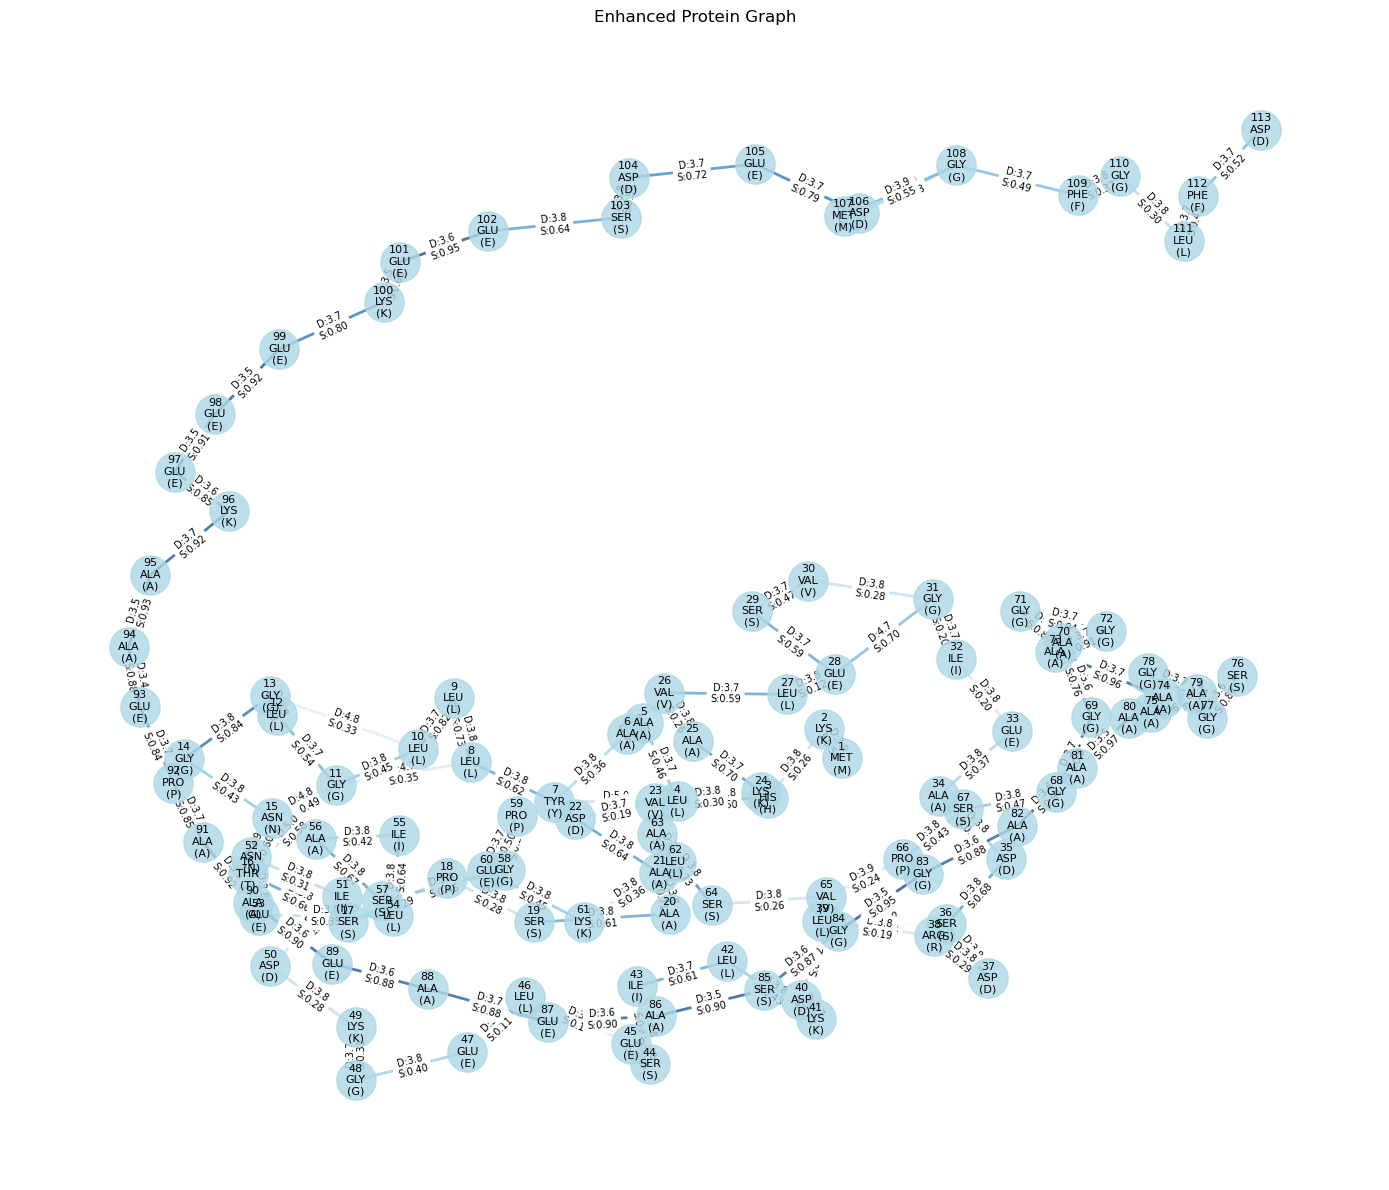

Number of nodes: 113
Number of edges: 120
Average degree: 2.12
Node embedding dimension: (1024,)


In [60]:
pdb_file = "example_pdb_files/allergen_1399_unrelaxed_rank_002_alphafold2_ptm_model_4_seed_000.pdb"  
protein_sequence = "MKHLAAYLLLGLGGNTSPSAADVKAVLESVGIEADSDRLDKLISELEGKDINELIASGPEKLASVPSGGAGGAAASGGAAAAGGSAEAEAAPEAAKEEEKEESDEDMGFGLFD" 
print(f"Length of the protein seq: {len(protein_sequence)}")

G, residue_list = create_enhanced_protein_graph(pdb_file, protein_sequence)

visualize_enhanced_protein_graph(G, residue_list)

Length of the protein seq: 113
Tokenized sequence: M K H L A A Y L L L G L G G N T S P S A A D V K A V L E S V G I E A D S D R L D K L I S E L E G K D I N E L I A S G P E K L A S V P S G G A G G A A A S G G A A A A G G S A E A E A A P E A A K E E E K E E S D E D M G F G L F D
Embeddings shape: (113, 1024)
Example embeddings: [[ 0.22068606  0.04368573 -0.08065286 ... -0.02268909 -0.03856529
  -0.07005817]
 [ 0.2530607  -0.09140749 -0.0795897  ... -0.04577831 -0.01940772
  -0.21498364]
 [ 0.18997994 -0.14016323  0.0137604  ... -0.0653484   0.13591135
  -0.02091298]
 [ 0.18623042 -0.2867412  -0.018804   ...  0.00147996  0.01984077
   0.00233994]
 [ 0.13393055 -0.16300054 -0.06242583 ... -0.25722933 -0.04949002
  -0.08432596]]
Graph created with 113 nodes and 120 edges


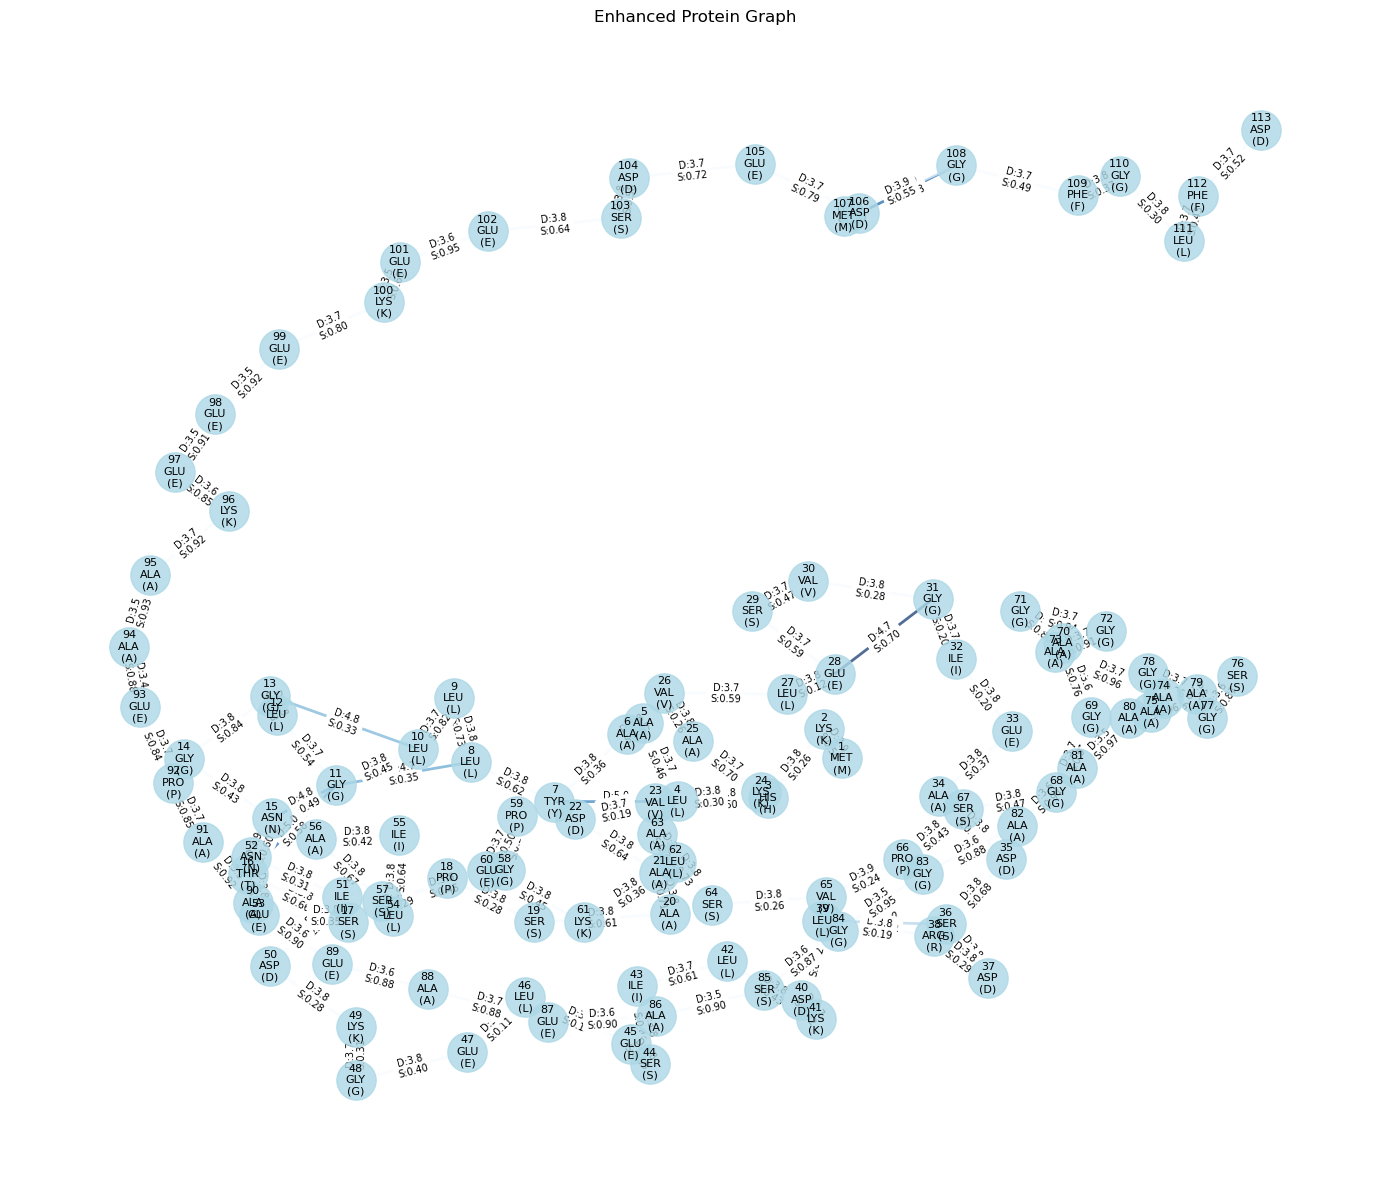

Number of nodes: 113
Number of edges: 120
Average degree: 2.12
Node embedding dimension: (1024,)


In [61]:
pdb_file = "example_pdb_files/allergen_1399_unrelaxed_rank_002_alphafold2_ptm_model_4_seed_000.pdb"  
protein_sequence = "MKHLAAYLLLGLGGNTSPSAADVKAVLESVGIEADSDRLDKLISELEGKDINELIASGPEKLASVPSGGAGGAAASGGAAAAGGSAEAEAAPEAAKEEEKEESDEDMGFGLFD" 
print(f"Length of the protein seq: {len(protein_sequence)}")

G, residue_list = create_protein_graph_with_consecutive_residue_edges(pdb_file, protein_sequence)

visualize_enhanced_protein_graph(G, residue_list)

In [62]:
from Bio.PDB import PDBParser

parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", "example_pdb_files/allergen_1399_unrelaxed_rank_002_alphafold2_ptm_model_4_seed_000.pdb" )
residue_count = 0
for model in structure:
    for chain in model:
        for residue in chain:
            if 'CA' in residue:
                residue_count += 1
print(f"PDB file contains {residue_count} residues with CA atoms")

PDB file contains 113 residues with CA atoms


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Length of the protein seq: 64
Tokenized sequence: M R L H H L L L A L L F L V L S A G S G F T Q G V R N S Q S C R R N K G I C V P I R C P G S M R Q I G T C L G A Q V K C C R R K
Embeddings shape: (64, 1024)
Example embeddings: [[-0.01939076  0.07004783 -0.08671396 ... -0.00149412  0.10689379
  -0.09197702]
 [ 0.06370018 -0.10445611 -0.10744516 ...  0.01788818 -0.03573392
  -0.08049203]
 [ 0.07994017 -0.05989574 -0.08308848 ...  0.05626592  0.1136182
   0.25439999]
 [ 0.05295396  0.027265   -0.04073931 ... -0.06332745  0.10123693
   0.11736155]
 [ 0.00816083  0.00448006 -0.03055859 ... -0.10091883  0.10640537
   0.07456776]]
Graph created with 64 nodes and 82 edges


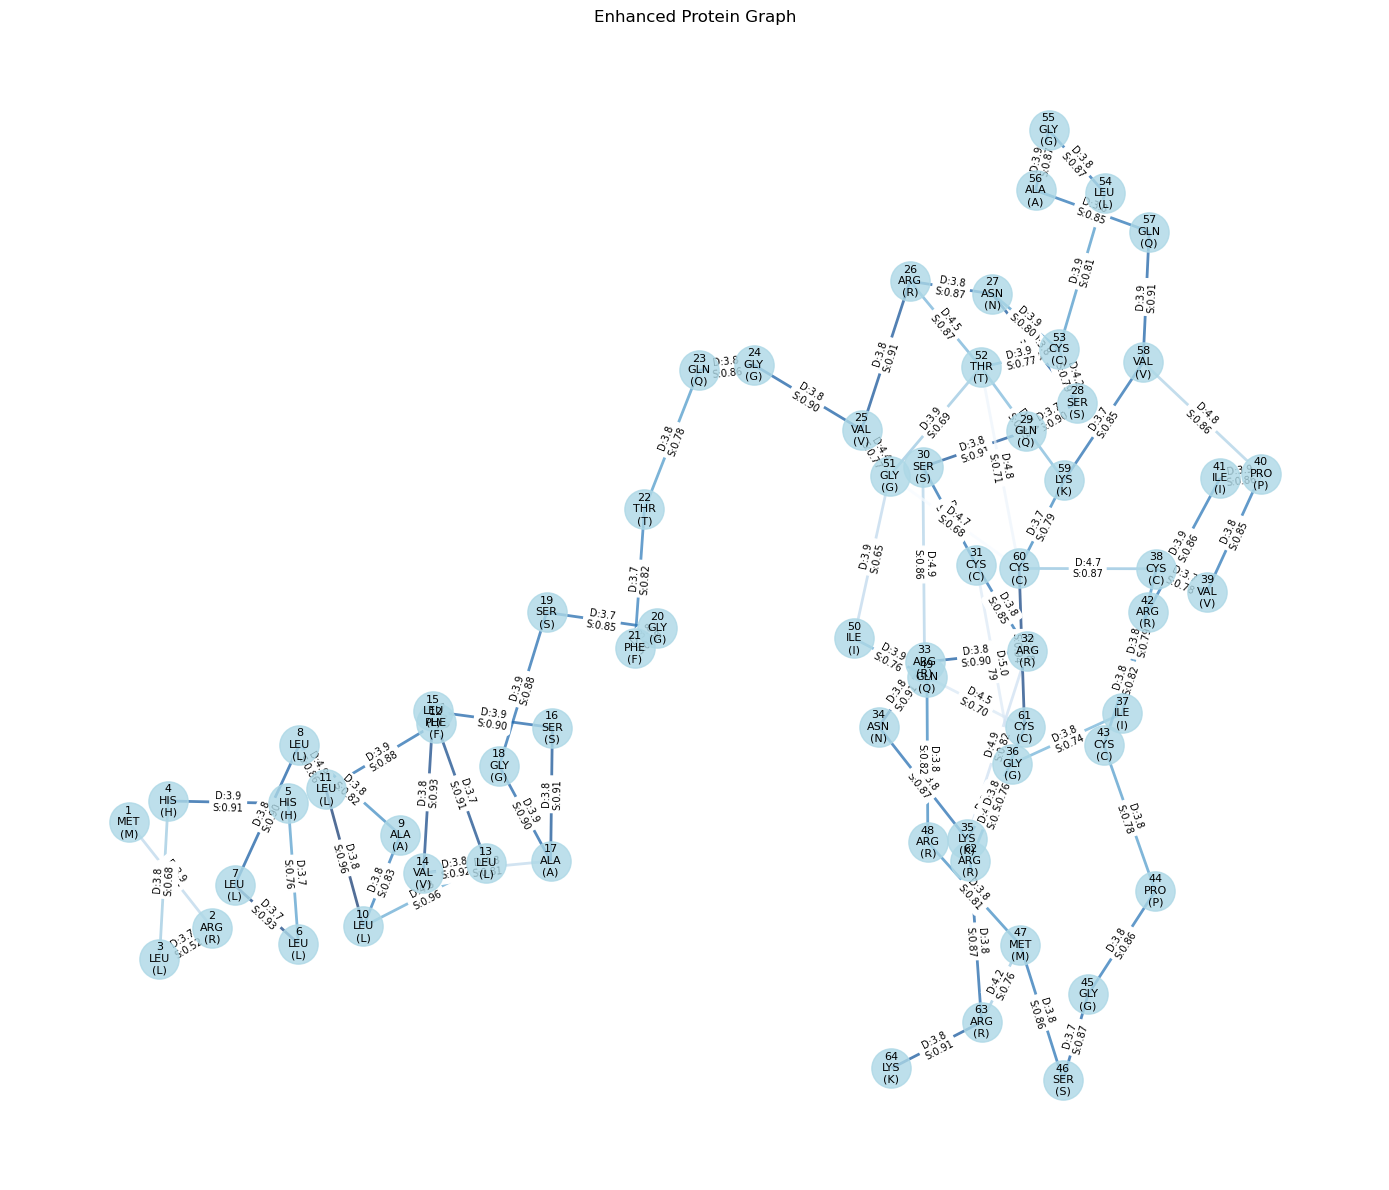

Number of nodes: 64
Number of edges: 82
Average degree: 2.56
Node embedding dimension: (1024,)


In [9]:
pdb_file = "example_pdb_files/non-allergen_31963_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"  
protein_sequence = "MRLHHLLLALLFLVLSAGSGFTQGVRNSQSCRRNKGICVPIRCPGSMRQIGTCLGAQVKCCRRK" 
print(f"Length of the protein seq: {len(protein_sequence)}")

G, residue_list = create_enhanced_protein_graph(pdb_file, protein_sequence)

visualize_enhanced_protein_graph(G, residue_list)

In [11]:
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", "example_pdb_files/non-allergen_31963_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"  )
residue_count = 0
for model in structure:
    for chain in model:
        for residue in chain:
            if 'CA' in residue:
                residue_count += 1
print(f"PDB file contains {residue_count} residues with CA atoms")

PDB file contains 64 residues with CA atoms


With the https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb#scrollTo=hUYApPElB30u notebook, all.train.fasta and all.test.fasta dataset's used for get the 3D representation with AlphaFold

Need to use train_structures/test_structures based on train/test fasta after all the AlphaFold coordinates done!

train_structures / test_structures are the pdb files that are came from AlphaFold for both all of the protein sequences in all.train.fasta and all.test.fasta

In [ ]:
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = read_fasta("Dataset/all.train.fasta")
test_sequences = read_fasta("Dataset/all.test.fasta")

train_graphs = process_pdb_directory(
    "train_structures", 
    train_sequences, 
    output_dir="train_graphs",
    distance_threshold=10.0,
    embedding_weight=0.5
)

test_graphs = process_pdb_directory(
    "test_structures", 
    test_sequences, 
    output_dir="test_graphs",
    distance_threshold=10.0,
    embedding_weight=0.5
)

In [12]:
from torch_geometric.data import Data

def convert_graph_to_pyg_format(G, label, protein_id):
    G = nx.convert_node_labels_to_integers(G) # added for out of bound error because of nx format and pyg differences (in terms of numerals)
    
    # Node features
    node_features = []
    for node in G.nodes:
        node_features.append(G.nodes[node]['embedding'])
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Edges
    edge_index = []
    edge_attr = []
    for u, v, data in G.edges(data=True):
        edge_index.extend([[u, v], [v, u]])
        edge_attr.extend([data['weight'], data['weight']])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    global_embedding = torch.tensor(G.graph['global_embedding'], dtype=torch.float).view(1, -1)

    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        global_embedding=global_embedding,
        y=torch.tensor([label], dtype=torch.long),
        protein_id=protein_id # added for printing the one by one protein seqeuences and their preds
    )

    return data

General Pipeline
* Using AlphaFold 3D coordinate structures --> build edges between residues (nodes) based on spatial closeness
* Using ProtBERT embeddings --> define node features (each amino acid/resiue has a 1024 dimensional embedding)
* Feeding these graphs into a graph neural network model to predict if a protein is allergenic or not.

* In graphs, each protein is a separate graph (protein sequences)
* Each graph can have a different number of nodes (residues)
* Graph layers (GraphSAGE, GATConv) work locally on nodes and their neighbors
* Operations are local: message passing between connected nodes

![Comparison Table](table.png)

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GATAllergenClassifier(torch.nn.Module):
    def __init__(self, node_features, hidden_channels=64):
        super(GATAllergenClassifier, self).__init__()
        self.conv1 = GATConv(node_features, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels*8, hidden_channels, heads=1)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 2)  # Binary classification
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.elu(x)
    
        x = global_mean_pool(x, batch)
    
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        #softmax_outputs = F.log_softmax(x, dim=1)
        #print(f"Softmax outputs: {softmax_outputs}")
        
        return F.log_softmax(x, dim=1)

In [127]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class ProteinGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels=1024, hidden_channels=256, out_channels=2):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, out_channels)
        )

    def forward(self, data):
        # Use edge weights if available
        #edge_weight = data.edge_attr.squeeze(1) if data.edge_attr is not None else None
        
        x = self.sage1(data.x, data.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.sage2(x, data.edge_index)
        x = F.relu(x)
        
        # Global mean pooling for graph-level classification
        x = global_mean_pool(x, data.batch)
        return self.classifier(x)

In [162]:
class SimplifiedProteinSAGE(torch.nn.Module):
    def __init__(self, in_channels=1024, hidden=128, out=2): 
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden, out)
        )

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = global_mean_pool(x, data.batch)
        return self.classifier(x)

In [14]:
from Bio import SeqIO

def get_labels_from_fasta(fasta_file):
    labels = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        protein_id = record.id.split()[0]  
        label = 1 if "allergen" in record.description else 0  
        labels[protein_id] = label
    return labels

In [15]:
train_labels = get_labels_from_fasta("Dataset/all.train.fasta") # real labels of train
test_labels = get_labels_from_fasta("Dataset/all.test.fasta") # real labels of test

In [16]:
len(train_labels), len(test_labels)

(5680, 1420)

This part is a try for the part of completed pdb files for only all.test.fasta with https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb#scrollTo=hUYApPElB30u

In [ ]:
def count_pdb_files_in_model_4(folder_path):
    files = os.listdir(folder_path)

    model_4_pdb_files = [f for f in files if "model_4" in f and f.endswith(".pdb")]
    
    return len(model_4_pdb_files), model_4_pdb_files

folder_path = "results_all"

count, model_4_pdb_files = count_pdb_files_in_model_4(folder_path)

print(f"Number of PDB files with 'model_4' in their name: {count}")

In [18]:
def process_pdb_directory(pdb_dir, sequences_dict, output_dir=None, distance_threshold=5.0, embedding_weight=0.5):
    graphs = {}
    
    for filename in os.listdir(pdb_dir):
        if filename.endswith('.pdb'):
            protein_id = filename.split("_unrelaxed")[0]
            
            if protein_id in sequences_dict:
                pdb_path = os.path.join(pdb_dir, filename)
                graph, _ = create_enhanced_protein_graph(
                    pdb_path, 
                    sequences_dict[protein_id], 
                    distance_threshold=distance_threshold,
                    embedding_weight=embedding_weight
                )
                
                graphs[protein_id] = graph
            
    
    return graphs

In [ ]:
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = read_fasta("Dataset/all.test.fasta")
test_sequences = read_fasta("Dataset/all.test.fasta")

train_graphs = process_pdb_directory(
    "train_structures", 
    train_sequences, 
    distance_threshold=10.0,
    embedding_weight=0.5
)

test_graphs = process_pdb_directory(
    "test_structures", 
    test_sequences, 
    distance_threshold=10.0,
    embedding_weight=0.5
)

Tokenized sequence: Q I K D L L V S S S T D L D T T L V L V N A I Y F K G M W K T A F N A E D T R E M P F H V T K Q E S K P V Q M M C M N N S F N V A T L P A E K M K I L E L P F A S G D L S M L V L L P D E V S D L E R I E K T I N F E K L T E W T N P N T M E K R R V K V Y L P Q M K I E E K Y N L T S V L M A L G M T D L F I P S A N L T G I S S A E S L K I S Q A V H G A F M E L S E D G I E M A G S T G V I E D I K H S P E S E Q F R A D H P F L F L I K H N P T N T I V Y F G R Y W S P
Embeddings shape: (232, 1024)
Example embeddings: [[ 0.04944897  0.15114328  0.07671342 ...  0.02399305  0.03893751
  -0.04733025]
 [-0.00441792  0.2111422  -0.04298404 ... -0.00139638  0.10491429
   0.04031372]
 [-0.04209237  0.14258477  0.00178644 ...  0.03697962  0.0009125
   0.03510885]
 [-0.03986705  0.12996045 -0.00060669 ... -0.00616623  0.02924807
   0.10227959]
 [-0.16290224  0.03245778 -0.03189386 ...  0.03623874  0.03394245
   0.05320065]]
Graph created with 232 nodes and 1774 edges
Tokenized sequenc

In [20]:
import pandas as pd
from torch_geometric.loader import DataLoader

labels_df = pd.read_csv("Dataset/processed_for_bert_test.csv")
#print(labels_df["Protein_ID"])
labels_dict = dict(zip(labels_df["Protein_ID"], labels_df["Label"]))
#print(f"Labels dictionary: {labels_dict}")

train_data = []
for protein_id, nx_graph in train_graphs.items():
    try:
        label = labels_dict[protein_id]
        pyg_data = convert_graph_to_pyg_format(nx_graph, label, protein_id)
        train_data.append(pyg_data)
    except KeyError:
        print(f"Skipping {protein_id} - label not found")

# 3. Convert test graphs
test_data = []
for protein_id, nx_graph in test_graphs.items():
    try:
        label = labels_dict[protein_id]
        pyg_data = convert_graph_to_pyg_format(nx_graph, label, protein_id)
        test_data.append(pyg_data)
    except KeyError:
        print(f"Skipping {protein_id} - label not found")

# 4. Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/var/folders/wb/2d5zv5zx3sb06ttllws04nz80000gn/T/ipykernel_1259/2032291305.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  node_features = torch.tensor(node_features, dtype=torch.float)


In [21]:
print(f"Label for first training sample: {train_data[0].y}")

Label for first training sample: tensor([1])


In [22]:
sample_graph = list(train_graphs.values())[0]
print(sample_graph)

Graph with 232 nodes and 1774 edges


In [152]:
import torch
from torch_geometric.loader import DataLoader

def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = F.cross_entropy(out, data.y)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def validate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Get class predictions
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total  # Accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ProteinGraphSAGE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, device)
    val_acc = validate(model, test_loader, device)
    print(f'Epoch {epoch:03d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')


Epoch 000 | Loss: 0.5146 | Val Acc: 0.8939
Epoch 001 | Loss: 0.2843 | Val Acc: 0.8939
Epoch 002 | Loss: 0.2045 | Val Acc: 0.9280
Epoch 003 | Loss: 0.1637 | Val Acc: 0.9394
Epoch 004 | Loss: 0.1294 | Val Acc: 0.9432
Epoch 005 | Loss: 0.0873 | Val Acc: 0.9318
Epoch 006 | Loss: 0.0866 | Val Acc: 0.9659
Epoch 007 | Loss: 0.0894 | Val Acc: 0.9697
Epoch 008 | Loss: 0.0610 | Val Acc: 0.9583
Epoch 009 | Loss: 0.0434 | Val Acc: 0.9735


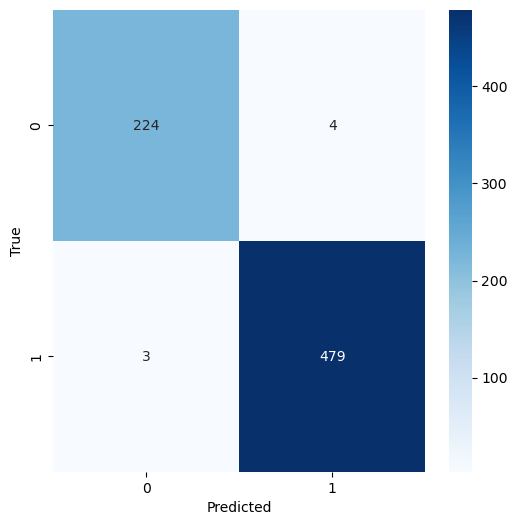

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, train_loader, device)

In [154]:
def validate_and_predict(model, loader, device, sequence_dict):
    model.eval()
    results = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            
            protein_ids = data.protein_id  
            labels = data.y.cpu().numpy()
        
            for pid, true, pred in zip(protein_ids, labels, preds):
                results.append({
                    "Protein_ID": pid,
                    "Sequence": sequence_dict[pid],
                    "True_Label": true,
                    "Predicted_Label": pred
                })
    
    return results

test_results = validate_and_predict(model, test_loader, device, test_sequences)

for i, result in enumerate(test_results[:10]):
    print(f"Sample {i+1}:")
    print(f"Protein ID: {result['Protein_ID']}")
    print(f"Sequence: {result['Sequence']}")
    print(f"True Label: {result['True_Label']}")
    print(f"Predicted Label: {result['Predicted_Label']}\n")
    print("-" * 50)

Sample 1:
Protein ID: allergen_761
Sequence: MKFIIAIAVCTLAVVCVSGEPKKHDYQNEFDFLLMQRIHEQMRKGEEALLHLQHQINTFEENPTKEMKEQILGEMDTIIALIDGVRGVLNRLMKRTDLDIFERYNVEIALKSNEILERDLKKEEQRVKKIEV
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 2:
Protein ID: allergen_1482
Sequence: MSWQTYVDDHLMCDIDGHRLTAAAIIGHDGSVWAQSSSFPQFKSDEVAAVMKDFDEPGSLAPTGLHLGGTKYMVIQGEPGAVIRGKKGSGGITVKRTGQALIIGIYDEPLTPGQCNMIVERLGDYLLDQGL
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 3:
Protein ID: non-allergen_7567
Sequence: MELYLDTSDVVAVKALSRIFPLAGVTTNPSIIAAGKKPLDVVLPQLHEAMGGQGRLFAQVMATTAEGMVNDALKLRSIIADIVVKVPVTAEGLAAIKMLKAEGIPTLGTAVYGAAQGLLSALAGAEYVAPYVNRIDAQGGSGIQTVTDLHQLLKMHAPQAKVLAASFKTPRQALDCLLAGCESITLPLDVAQQMISYPAVDAAVAKFEQDWQGAFGRTSI
True Label: 0
Predicted Label: 0

--------------------------------------------------
Sample 4:
Protein ID: non-allergen_7322
Sequence: MEQSVANLVDMRDVSFTRGNRCIFDNISLTVPRGKITAIMGPSGIGKTTLLRLIGGQIAPDHGEILFD

In [163]:
model = SimplifiedProteinSAGE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, device)
    val_acc = validate(model, test_loader, device)
    print(f'Epoch {epoch:03d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 000 | Loss: 0.4833 | Val Acc: 0.9015
Epoch 001 | Loss: 0.2894 | Val Acc: 0.9205
Epoch 002 | Loss: 0.2128 | Val Acc: 0.9242
Epoch 003 | Loss: 0.1788 | Val Acc: 0.9242
Epoch 004 | Loss: 0.1670 | Val Acc: 0.9432
Epoch 005 | Loss: 0.1389 | Val Acc: 0.9394
Epoch 006 | Loss: 0.1272 | Val Acc: 0.9432
Epoch 007 | Loss: 0.1113 | Val Acc: 0.9545
Epoch 008 | Loss: 0.1022 | Val Acc: 0.9621
Epoch 009 | Loss: 0.0880 | Val Acc: 0.9697


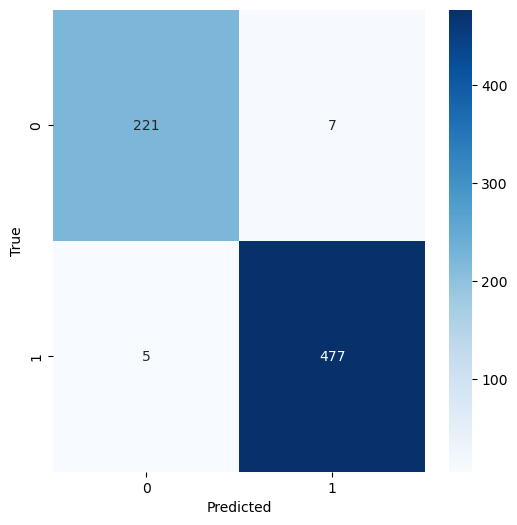

In [164]:
plot_confusion_matrix(model, train_loader, device)

In [165]:
test_results = validate_and_predict(model, test_loader, device, test_sequences)

for i, result in enumerate(test_results[:10]):
    print(f"Sample {i+1}:")
    print(f"Protein ID: {result['Protein_ID']}")
    print(f"Sequence: {result['Sequence']}")
    print(f"True Label: {result['True_Label']}")
    print(f"Predicted Label: {result['Predicted_Label']}\n")
    print("-" * 50)

Sample 1:
Protein ID: allergen_761
Sequence: MKFIIAIAVCTLAVVCVSGEPKKHDYQNEFDFLLMQRIHEQMRKGEEALLHLQHQINTFEENPTKEMKEQILGEMDTIIALIDGVRGVLNRLMKRTDLDIFERYNVEIALKSNEILERDLKKEEQRVKKIEV
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 2:
Protein ID: allergen_1482
Sequence: MSWQTYVDDHLMCDIDGHRLTAAAIIGHDGSVWAQSSSFPQFKSDEVAAVMKDFDEPGSLAPTGLHLGGTKYMVIQGEPGAVIRGKKGSGGITVKRTGQALIIGIYDEPLTPGQCNMIVERLGDYLLDQGL
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 3:
Protein ID: non-allergen_7567
Sequence: MELYLDTSDVVAVKALSRIFPLAGVTTNPSIIAAGKKPLDVVLPQLHEAMGGQGRLFAQVMATTAEGMVNDALKLRSIIADIVVKVPVTAEGLAAIKMLKAEGIPTLGTAVYGAAQGLLSALAGAEYVAPYVNRIDAQGGSGIQTVTDLHQLLKMHAPQAKVLAASFKTPRQALDCLLAGCESITLPLDVAQQMISYPAVDAAVAKFEQDWQGAFGRTSI
True Label: 0
Predicted Label: 0

--------------------------------------------------
Sample 4:
Protein ID: non-allergen_7322
Sequence: MEQSVANLVDMRDVSFTRGNRCIFDNISLTVPRGKITAIMGPSGIGKTTLLRLIGGQIAPDHGEILFD

This part is for the GATConv model training of a base case (same settings only model is different)

In [31]:
import torch
from torch_geometric.loader import DataLoader

def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = F.cross_entropy(out, data.y)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def validate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Get class predictions
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total  # Accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GATAllergenClassifier(node_features=1024, hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, device)
    val_acc = validate(model, test_loader, device)
    print(f'Epoch {epoch:03d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 000 | Loss: 0.5722 | Val Acc: 0.8030
Epoch 001 | Loss: 0.3576 | Val Acc: 0.9091
Epoch 002 | Loss: 0.2545 | Val Acc: 0.9167
Epoch 003 | Loss: 0.1920 | Val Acc: 0.9167
Epoch 004 | Loss: 0.1616 | Val Acc: 0.9356
Epoch 005 | Loss: 0.1386 | Val Acc: 0.9470
Epoch 006 | Loss: 0.1212 | Val Acc: 0.9508
Epoch 007 | Loss: 0.1151 | Val Acc: 0.9659
Epoch 008 | Loss: 0.1151 | Val Acc: 0.9545
Epoch 009 | Loss: 0.0783 | Val Acc: 0.9621


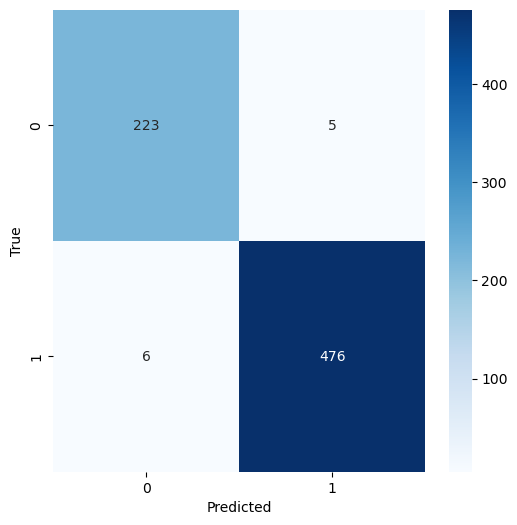

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, train_loader, device)

In [33]:
def validate_and_predict(model, loader, device, sequence_dict):
    model.eval()
    results = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            
            protein_ids = data.protein_id  
            labels = data.y.cpu().numpy()
        
            for pid, true, pred in zip(protein_ids, labels, preds):
                results.append({
                    "Protein_ID": pid,
                    "Sequence": sequence_dict[pid],
                    "True_Label": true,
                    "Predicted_Label": pred
                })
    
    return results

test_results = validate_and_predict(model, test_loader, device, test_sequences)

for i, result in enumerate(test_results[:10]):
    print(f"Sample {i+1}:")
    print(f"Protein ID: {result['Protein_ID']}")
    print(f"Sequence: {result['Sequence']}")
    print(f"True Label: {result['True_Label']}")
    print(f"Predicted Label: {result['Predicted_Label']}\n")
    print("-" * 50)

Sample 1:
Protein ID: allergen_761
Sequence: MKFIIAIAVCTLAVVCVSGEPKKHDYQNEFDFLLMQRIHEQMRKGEEALLHLQHQINTFEENPTKEMKEQILGEMDTIIALIDGVRGVLNRLMKRTDLDIFERYNVEIALKSNEILERDLKKEEQRVKKIEV
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 2:
Protein ID: allergen_1482
Sequence: MSWQTYVDDHLMCDIDGHRLTAAAIIGHDGSVWAQSSSFPQFKSDEVAAVMKDFDEPGSLAPTGLHLGGTKYMVIQGEPGAVIRGKKGSGGITVKRTGQALIIGIYDEPLTPGQCNMIVERLGDYLLDQGL
True Label: 1
Predicted Label: 1

--------------------------------------------------
Sample 3:
Protein ID: non-allergen_7567
Sequence: MELYLDTSDVVAVKALSRIFPLAGVTTNPSIIAAGKKPLDVVLPQLHEAMGGQGRLFAQVMATTAEGMVNDALKLRSIIADIVVKVPVTAEGLAAIKMLKAEGIPTLGTAVYGAAQGLLSALAGAEYVAPYVNRIDAQGGSGIQTVTDLHQLLKMHAPQAKVLAASFKTPRQALDCLLAGCESITLPLDVAQQMISYPAVDAAVAKFEQDWQGAFGRTSI
True Label: 0
Predicted Label: 0

--------------------------------------------------
Sample 4:
Protein ID: non-allergen_7322
Sequence: MEQSVANLVDMRDVSFTRGNRCIFDNISLTVPRGKITAIMGPSGIGKTTLLRLIGGQIAPDHGEILFD